# Cifar-10 image classification

In [ ]:
# Include torchtrainer in the import path
import sys
sys.path.insert(0, '../../')

In [7]:
# Initial imports and device setting
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from torch.functional import F
import torchvision
import torchvision.transforms as tv_transforms
import torchtrainer
from torchtrainer.learner import Learner
from torchtrainer.models import resnet18

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# Create dataloaders
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

transform_train = tv_transforms.Compose([
    tv_transforms.RandomCrop(32, padding=4),
    tv_transforms.RandomHorizontalFlip(),
    tv_transforms.ToTensor(),
    tv_transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = tv_transforms.Compose([
    tv_transforms.ToTensor(),
    tv_transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
%%time

def accuracy(input, target):
    """Compare predictions to targets."""
    
    res_labels = torch.argmax(input.detach(), dim=1)
    return (res_labels==target).float().mean()

loss_func = F.cross_entropy
model = resnet18.resnet18(num_classes=10)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

learner = Learner(model, loss_func, optimizer, trainloader, testloader, scheduler, 
                       acc_funcs={'acc':accuracy}, main_acc_func='acc')

learner.fit(200)

Wall time: 127 ms


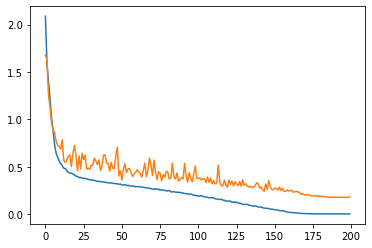

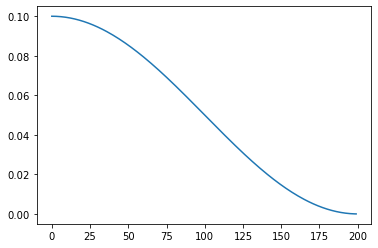

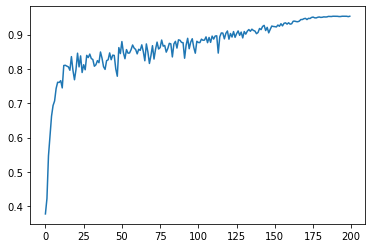

In [11]:
# Plot loss and accuracy history
plt.figure()
plt.plot(learner.train_loss_history)
plt.plot(learner.valid_loss_history)
plt.figure()
plt.plot(learner.lr_history)
plt.figure()
plt.plot(learner.acc_funcs_history['acc'])

In [17]:
# After training, we can load the model for inference. Be sure to first recreate `model` 
# exactly as it was defined during training
checkpoint = torch.load('learner.tar')
model.load_state_dict(checkpoint['model_state'])
  
model.to(device)
model.eval()

img, label = testset[0]
img = img.unsqueeze(0).to('cuda')
with torch.no_grad():
    prediction = model(img)
    
print(f'Label: {label}, Predicted: {prediction.argmax()}')

Label: 3, Predicted: 3
